In [418]:
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from shapely.geometry import Point
import pandas as pd
import glob

In [419]:
faults = gpd.read_file("../data/outages/ukpn-iis.geojson")

In [420]:
faults.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [421]:
faults.head()

,incident_reference,restoration_stage,start_date_time,end_date_time,customers_restored,reinteruption_stage,mei_code,cause_code,cont_cause_code,damage,...,incident_count,incident_to_be_excluded_from_iis,ee_coding_only_for_additional_incidents,licence_area,regulatory_year,unique_identifier,substation,sitefunctionallocation,spatial_coordinates,geometry
0,FREP-10003-I,3,2024-03-30 16:52:00+00:00,2024-03-30 19:14:00+00:00,1,N,90,75,None,0,...,0,None,None,EPN,2023-24,FREP-10003-I3,EAST BAY PRIMARY,EPN-S0000000H3036,None,POINT (0.91522 51.88858)
1,FREP-10003-I,2,2024-03-30 16:52:00+00:00,2024-03-30 17:44:00+00:00,16,N,90,75,None,0,...,0,None,None,EPN,2023-24,FREP-10003-I2,EAST BAY PRIMARY,EPN-S0000000H3036,None,POINT (0.91522 51.88858)
2,FREP-10895-O,1,2022-10-21 02:00:00+00:00,2022-10-21 03:00:00+00:00,0,N,41,71,None,1,...,1,None,None,EPN,2022-23,FREP-10895-O1,EAST BAY PRIMARY,EPN-S0000000H3036,None,POINT (0.91522 51.88858)
3,FREP-10790-L,2,2023-01-11 01:42:00+00:00,2023-01-11 01:52:00+00:00,0,N,1,71,None,1,...,1,None,None,LPN,2022-23,FREP-10790-L2,BENGEWORTH RD 11KV,LPN-S000000000907,None,POINT (-0.09664 51.46731)
4,FREP-10006-I,1,2024-03-30 16:50:00+00:00,2024-03-31 15:32:00+00:00,1,N,59,57,None,1,...,1,None,None,EPN,2023-24,FREP-10006-I1,WETHERSFIELD PRIMARY,EPN-S0000000H3065,None,POINT (0.48839 51.96221)


In [422]:
faults.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 237901 entries, 0 to 237900
Data columns (total 21 columns):
 #   Column                                   Non-Null Count   Dtype              
---  ------                                   --------------   -----              
 0   incident_reference                       237901 non-null  object             
 1   restoration_stage                        237901 non-null  int32              
 2   start_date_time                          237901 non-null  datetime64[ms, UTC]
 3   end_date_time                            237901 non-null  datetime64[ms, UTC]
 4   customers_restored                       237901 non-null  int32              
 5   reinteruption_stage                      237901 non-null  object             
 6   mei_code                                 237901 non-null  object             
 7   cause_code                               237901 non-null  object             
 8   cont_cause_code                          3133 

In [423]:
dropped_columns = [
    'unique_identifier',
    'sitefunctionallocation',
    'regulatory_year',
    'ee_coding_only_for_additional_incidents',
    'incident_to_be_excluded_from_iis',
    'incident_reference',      
    'restoration_stage',  
    'reinteruption_stage',      
    'cont_cause_code',           
    'incident_count',                          
    'substation',                
    'spatial_coordinates'   
]
faults = faults.drop(columns=dropped_columns)

In [424]:
faults.head()

,start_date_time,end_date_time,customers_restored,mei_code,cause_code,damage,ee_coding,licence_area,geometry
0,2024-03-30 16:52:00+00:00,2024-03-30 19:14:00+00:00,1,90,75,0,None,EPN,POINT (0.91522 51.88858)
1,2024-03-30 16:52:00+00:00,2024-03-30 17:44:00+00:00,16,90,75,0,None,EPN,POINT (0.91522 51.88858)
2,2022-10-21 02:00:00+00:00,2022-10-21 03:00:00+00:00,0,41,71,1,None,EPN,POINT (0.91522 51.88858)
3,2023-01-11 01:42:00+00:00,2023-01-11 01:52:00+00:00,0,1,71,1,None,LPN,POINT (-0.09664 51.46731)
4,2024-03-30 16:50:00+00:00,2024-03-31 15:32:00+00:00,1,59,57,1,None,EPN,POINT (0.48839 51.96221)


In [425]:
faults_eda = faults.copy()

In [426]:
mei_code_mapping = {
    # HV+ Voltages
    '0': 'OH Lines (HV+)',
    '1': 'UG Cables (HV+)',
    '2': 'Switchgear/Fusegear (HV+)',
    '2A': 'Busbars (HV+)',
    '2B': 'Switchgear & Fusegear (HV+)',
    '3': 'Transformers/Reactors (HV+)',
    '4': 'Protection (HV+)',
    '5': 'Miscellaneous (HV+)',
    '6': 'Surge Divertor (HV+)',
    '8': 'Not Applicable (HV+)',
    '9': 'Unknown (HV+)',
    'X': 'None (HV+)',
    
    # LV Overhead Mains
    '00': 'Overhead Main (LV)',
    '01': 'OH Main - Bare Conductors (LV)',
    '02': 'OH Main - Insulated Conductors (LV)',
    '03': 'OH Main – ABC (LV)',
    '09': 'OH Main - Mixed Conductors (LV)',
    
    # LV Overhead Services
    '10': 'Overhead Service (metered) (LV)',
    '11': 'OH Service - Bare Conductors (LV)',
    '12': 'OH Service - Insulated Conductors (LV)',
    '13': 'OH Service - Mixed Conductors (LV)',
    '14': 'OH Service - Concentric (LV)',
    '15': 'OH Service - Duplex/Triplex (LV)',
    '16': 'OH Service – ABC (LV)',
    '19': 'OH Service - Other (LV)',
    
    # LV Surface Wiring
    '20': 'Surface Wiring Main (LV)',
    '21': 'Surface Wiring Main - Outdoor (LV)',
    '22': 'Surface Wiring Main - Indoor (LV)',
    '30': 'Surface Wiring Service (LV)',
    
    # LV Underground Mains
    '41': 'UG Main – PLCS (LV)',
    '42': 'UG Main - Consac (LV)',
    '44': 'UG Main - Waveform (Alpex) (LV)',
    '45': 'UG Main - Districable (LV)',
    '49': 'UG Main - Mixed/Unclassified (LV)',
    
    # LV Underground Services
    '51': 'UG Service - PLCS (LV)',
    '52': 'UG Service - Plastic Insulated Concentric (LV)',
    '53': 'UG Service - Consac (LV)',
    '54': 'UG Service - Waveform (LV)',
    '55': 'UG Service - Districable (LV)',
    '59': 'UG Service - Mixed/Unclassified (LV)',
    
    # LV Switchgear/Fusegear
    '60': 'Switchgear/Fusegear (LV)',
    '61': 'Switchgear - Circuit Breaker (LV)',
    '62': 'Switchgear - Pole Mounted Isolator (LV)',
    '63': 'Switchgear - S/S Fuseboard/Pillar/TMFC (LV)',
    '64': 'Switchgear - Pole Mounted Fusegear (LV)',
    '65': 'Switchgear - Street Feeder Pillar (LV)',
    '66': 'Switchgear - Multi-Service Pillar/Turret (LV)',
    '67': 'Switchgear - Linkbox (LV)',
    '68': 'Switchgear - Fused Wall Box (LV)',
    '69': 'Switchgear - Other (LV)',
    
    # LV Cut-outs
    '71': 'Cut-outs (metered) (LV)',
    '72': 'OH Service Cut-Out Metered (LV)',
    '73': 'UG Service Cut-Out Metered (LV)',
    '82': 'OH Service Unmetered (LV)',
    '83': 'UG Service Unmetered (LV)',
    
    # LV Other/Unknown
    '90': 'Other (LV)',
    '99': 'Other/Unknown (LV)',
    
    # Suspect Faults (LV)
    'S1': 'Suspect UG Fault - possibly overload (LV)',
    'S2': 'Suspect UG Fault - possibly damage (LV)',
    'S3': 'Suspect UG Fault - other (LV)',
    'S4': 'Suspect OH Fault - possibly overload (LV)',
    'S5': 'Suspect OH Fault - possibly tree related (LV)',
    'S6': 'Suspect OH Fault - other (LV)',
    'X': 'None'
}

In [427]:
cause_code_mapping = {
    '01': 'Lightning',
    '02': 'Rain',
    '03': 'Snow and Ice',
    '04': 'Ice',
    '05': 'Freezing Fog & Frost',
    '06': 'Wind and gale (including windborne material)',
    '07': 'Solar heat',
    '10': 'Airborne deposits (excluding windborne material)',
    '14': 'Condensation',
    '15': 'Corrosion',
    '16': 'Mechanical shock or vibration',
    '17': 'Ground subsidence',
    '18': 'Flooding',
    '19': 'Fire not due to faults',
    '21': 'Windborne Material',
    '22': 'Disruption of intended indoor environment',
    '23': 'Falling live trees (not felled)',
    '24': 'Falling dead trees (not felled)',
    '25': 'Growing Trees',
    '26': 'Corrosion due to atmosphere/environment',
    '30': 'Birds (including swans and geese)',
    '32': 'Vermin, wild animals and insects',
    '33': 'Farm and domestic animals',
    '39': 'Wilful damage, interference',
    '40': 'Metal theft',
    '41': 'Accidental Contact by Cable TV companies',
    '42': 'Accidental Contact by Public Telecoms Operator',
    '43': 'Accidental Contact by Gas Company',
    '44': 'Accidental Contact by water/sewage companies',
    '45': 'Accidental Contact by highway authorities',
    '48': 'Accidental Contact Involving farm workers',
    '49': 'Accidental Contact Involving aircraft',
    '50': 'Accidental Contact by private individuals',
    '53': 'Accidental Contact by unknown third parties',
    '54': 'Accidental Contact by local building authorities',
    '55': 'Accidental Contact by private developers',
    '56': 'Accidental Contact involving leisure pursuits',
    '57': 'Accidental Contact by other third parties',
    '58': '3rd Party - By Cable Communications Operators',
    '60': 'Accidental Contact by DNOC or their contractors',
    '61': 'Switching error by DNOC staff',
    '62': 'Testing or commissioning error by DNOC staff',
    '63': 'Incorrect or inadequate system records',
    '64': 'Corrosion due to Bi-Metal Contact',
    '65': 'Incorrect application of equipment by DNOC staff',
    '66': 'Faulty installation or construction by DNOC staff',
    '67': 'Load current above previous assessment',
    '68': 'Incorrect or Unsuitable protection settings',
    '69': 'Unsuitable protection settings',
    '70': 'Inadequate rupturing or short circuit capacity',
    '71': 'Deterioration due to ageing or wear',
    '72': 'Fault on equipment faulting adjacent equipment',
    '73': 'Unsuitable paralleling conditions',
    '74': 'Failure of infeed from Adjacent Distribution Network',
    '75': 'Operational or safety restriction',
    '76': 'Extension of Fault Zone due to Fault Switching',
    '77': 'Inadequate or faulty maintenance',
    '78': 'Extension of Fault Zone due to incorrect operation',
    '80': 'Failure of Supply from Generating Company or NGC',
    '81': 'Switching Error by Contractors',
    '82': 'Testing or commissioning error by Contractors',
    '83': 'Incorrect application of equipment by Contractors',
    '84': 'Faulty Installation or Construction by Contractors',
    '85': 'Fault on customers network',
    '86': 'Interruption to remove local generator',
    '87': 'Local generation failure (isolated system)',
    '88': 'Distribution equipment affected by NGC personnel',
    '89': 'Distribution equipment affected by private generator',
    '90': 'Faulty manufacturing, design, assembly or materials',
    '97': 'No Fault Found',
    '98': 'Cause Unclassified',
    '99': 'Cause Unknown',
    'A1': 'Transient Fault - No Repair',
    'A2': 'Premature Insulation Failure',
    'D': 'Dummy - Do not set',
    'X': 'NONE'
}

In [428]:
faults_eda['mei_code'] = faults_eda['mei_code'].astype(str)
faults_eda['cause_code'] = faults_eda['cause_code'].astype(str)

faults_eda['mei_description'] = faults_eda['mei_code'].map(mei_code_mapping).fillna("Unknown_MEI:" + faults_eda['mei_code'])
faults_eda['cause_description'] = faults_eda['cause_code'].map(cause_code_mapping).fillna("Unknown_Cause:" + faults_eda['cause_code'])

faults_eda['voltage_level'] = faults_eda['mei_description'].str.extract(r'(HV\+|LV)')

In [429]:
faults_eda['total_minutes_lost'] = (faults_eda['end_date_time'] - faults_eda['start_date_time']).dt.total_seconds() / 60

In [430]:
drop_columns_eda = ['mei_code', 'cause_code']

faults_eda.drop(columns=drop_columns_eda, inplace=True)

In [431]:
faults_eda.head()

,start_date_time,end_date_time,customers_restored,damage,ee_coding,licence_area,geometry,mei_description,cause_description,voltage_level,total_minutes_lost
0,2024-03-30 16:52:00+00:00,2024-03-30 19:14:00+00:00,1,0,None,EPN,POINT (0.91522 51.88858),Other (LV),Operational or safety restriction,LV,142.0
1,2024-03-30 16:52:00+00:00,2024-03-30 17:44:00+00:00,16,0,None,EPN,POINT (0.91522 51.88858),Other (LV),Operational or safety restriction,LV,52.0
2,2022-10-21 02:00:00+00:00,2022-10-21 03:00:00+00:00,0,1,None,EPN,POINT (0.91522 51.88858),UG Main – PLCS (LV),Deterioration due to ageing or wear,LV,60.0
3,2023-01-11 01:42:00+00:00,2023-01-11 01:52:00+00:00,0,1,None,LPN,POINT (-0.09664 51.46731),UG Cables (HV+),Deterioration due to ageing or wear,HV+,10.0
4,2024-03-30 16:50:00+00:00,2024-03-31 15:32:00+00:00,1,1,None,EPN,POINT (0.48839 51.96221),UG Service - Mixed/Unclassified (LV),Accidental Contact by other third parties,LV,1362.0


[None '3A' '1A' '1B' '1C' '9A' '2A']
ee_coding
2A    0.033138
3A    0.031634
1A    0.019241
1B    0.010093
1C    0.005317
9A    0.000578
Name: proportion, dtype: float64


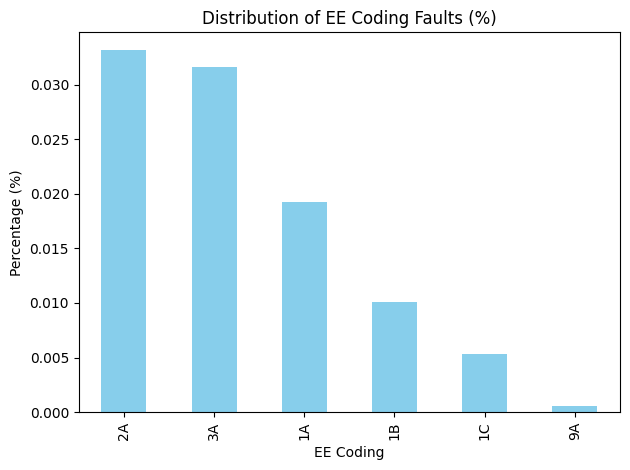

In [432]:
unique_ee_codes = faults_eda['ee_coding'].unique()
print(unique_ee_codes)

ee_coding_percent = faults_eda['ee_coding'].value_counts(normalize=True) * .10
print(ee_coding_percent)

ee_coding_percent.plot(kind='bar', color='skyblue')
plt.ylabel('Percentage (%)')
plt.xlabel('EE Coding')
plt.title('Distribution of EE Coding Faults (%)')
plt.tight_layout()
plt.show()

In [433]:
boundary = gpd.read_file("../data/boundary/uk-power-networks-boundary.geojson")

print("Boundary CRS:", boundary.crs)

bbox = boundary.total_bounds
print(f"Bounding Box: {bbox}")

Boundary CRS: EPSG:4326
Bounding Box: [-1.14072636 50.73258482  1.76404059 52.99007949]


In [434]:
nc_files = glob.glob("../data/weather/era5/Precip-*.nc")
ds = xr.open_mfdataset(nc_files, combine='by_coords')
print(ds)

<xarray.Dataset> Size: 18MB
Dimensions:     (valid_time: 35064, latitude: 10, longitude: 12)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 281kB 2021-01-01 ... 2024-12-31T2...
  * latitude    (latitude) float64 80B 52.98 52.73 52.48 ... 51.23 50.98 50.73
  * longitude   (longitude) float64 96B -1.14 -0.89 -0.64 ... 1.11 1.36 1.61
    expver      (valid_time) <U4 561kB dask.array<chunksize=(17520,), meta=np.ndarray>
Data variables:
    tp          (valid_time, latitude, longitude) float32 17MB dask.array<chunksize=(17520, 10, 12), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-17T10:59 GRIB to CDM+CF via cfgrib-0.9.1...


In [435]:
rain = ds['tp'].to_dataframe().reset_index()

mask = (
    (rain['longitude'].between(bbox[0], bbox[2])) &
    (rain['latitude'].between(bbox[1], bbox[3]))
)

rain = rain[mask].copy()

rain['geometry'] = [Point(xy) for xy in zip(rain.longitude, rain.latitude)]
rain = gpd.GeoDataFrame(rain, geometry='geometry', crs='EPSG:4326')


In [436]:
rain.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [437]:
rain.tail()

,valid_time,latitude,longitude,number,expver,tp,geometry
4207663,2024-12-31 23:00:00,50.98,0.61,0,0001,0.000040,POINT (0.61 50.98)
4207664,2024-12-31 23:00:00,50.98,0.86,0,0001,0.000011,POINT (0.86 50.98)
4207665,2024-12-31 23:00:00,50.98,1.11,0,0001,0.000006,POINT (1.11 50.98)
4207666,2024-12-31 23:00:00,50.98,1.36,0,0001,0.000006,POINT (1.36 50.98)
4207667,2024-12-31 23:00:00,50.98,1.61,0,0001,0.000003,POINT (1.61 50.98)


In [438]:
rain['rainfall_mm'] = rain['tp'] * 1000

In [439]:
rain.tail()

,valid_time,latitude,longitude,number,expver,tp,geometry,rainfall_mm
4207663,2024-12-31 23:00:00,50.98,0.61,0,0001,0.000040,POINT (0.61 50.98),0.039965
4207664,2024-12-31 23:00:00,50.98,0.86,0,0001,0.000011,POINT (0.86 50.98),0.011444
4207665,2024-12-31 23:00:00,50.98,1.11,0,0001,0.000006,POINT (1.11 50.98),0.005648
4207666,2024-12-31 23:00:00,50.98,1.36,0,0001,0.000006,POINT (1.36 50.98),0.005946
4207667,2024-12-31 23:00:00,50.98,1.61,0,0001,0.000003,POINT (1.61 50.98),0.002548


In [440]:
rain = rain.drop(columns=['tp', 'expver', 'number'])

rain.tail()

,valid_time,latitude,longitude,geometry,rainfall_mm
4207663,2024-12-31 23:00:00,50.98,0.61,POINT (0.61 50.98),0.039965
4207664,2024-12-31 23:00:00,50.98,0.86,POINT (0.86 50.98),0.011444
4207665,2024-12-31 23:00:00,50.98,1.11,POINT (1.11 50.98),0.005648
4207666,2024-12-31 23:00:00,50.98,1.36,POINT (1.36 50.98),0.005946
4207667,2024-12-31 23:00:00,50.98,1.61,POINT (1.61 50.98),0.002548


In [441]:
rain['valid_time'] = pd.to_datetime(rain['valid_time'])

rain = rain.set_index('valid_time')

daily_rain = (
    rain.groupby(['latitude', 'longitude'])
    .resample('D')
    .agg({'rainfall_mm': 'sum'})
    .reset_index()
)

daily_rain['geometry'] = [Point(xy) for xy in zip(daily_rain.longitude, daily_rain.latitude)]

rain = gpd.GeoDataFrame(daily_rain, geometry='geometry', crs='EPSG:4326')

In [442]:
rain.head()

,latitude,longitude,valid_time,rainfall_mm,geometry
0,50.98,-1.14,2021-01-01,1.242265,POINT (-1.14 50.98)
1,50.98,-1.14,2021-01-02,0.324070,POINT (-1.14 50.98)
2,50.98,-1.14,2021-01-03,0.368182,POINT (-1.14 50.98)
3,50.98,-1.14,2021-01-04,0.637415,POINT (-1.14 50.98)
4,50.98,-1.14,2021-01-05,0.658121,POINT (-1.14 50.98)


In [443]:
rain = rain.drop(columns=['latitude', 'longitude'])

In [444]:
faults.head()

,start_date_time,end_date_time,customers_restored,mei_code,cause_code,damage,ee_coding,licence_area,geometry
0,2024-03-30 16:52:00+00:00,2024-03-30 19:14:00+00:00,1,90,75,0,None,EPN,POINT (0.91522 51.88858)
1,2024-03-30 16:52:00+00:00,2024-03-30 17:44:00+00:00,16,90,75,0,None,EPN,POINT (0.91522 51.88858)
2,2022-10-21 02:00:00+00:00,2022-10-21 03:00:00+00:00,0,41,71,1,None,EPN,POINT (0.91522 51.88858)
3,2023-01-11 01:42:00+00:00,2023-01-11 01:52:00+00:00,0,1,71,1,None,LPN,POINT (-0.09664 51.46731)
4,2024-03-30 16:50:00+00:00,2024-03-31 15:32:00+00:00,1,59,57,1,None,EPN,POINT (0.48839 51.96221)


In [445]:
faults['ee_coding'] = faults['ee_coding'].fillna(0)
faults['total_minutes_lost'] = (faults['end_date_time'] - faults['start_date_time']).dt.total_seconds() / 60

In [446]:
faults.head()

,start_date_time,end_date_time,customers_restored,mei_code,cause_code,damage,ee_coding,licence_area,geometry,total_minutes_lost
0,2024-03-30 16:52:00+00:00,2024-03-30 19:14:00+00:00,1,90,75,0,0,EPN,POINT (0.91522 51.88858),142.0
1,2024-03-30 16:52:00+00:00,2024-03-30 17:44:00+00:00,16,90,75,0,0,EPN,POINT (0.91522 51.88858),52.0
2,2022-10-21 02:00:00+00:00,2022-10-21 03:00:00+00:00,0,41,71,1,0,EPN,POINT (0.91522 51.88858),60.0
3,2023-01-11 01:42:00+00:00,2023-01-11 01:52:00+00:00,0,1,71,1,0,LPN,POINT (-0.09664 51.46731),10.0
4,2024-03-30 16:50:00+00:00,2024-03-31 15:32:00+00:00,1,59,57,1,0,EPN,POINT (0.48839 51.96221),1362.0


In [447]:
faults.shape

(237901, 10)

In [448]:
faults.isna().sum()

start_date_time          0
end_date_time            0
customers_restored       0
mei_code                 0
cause_code               0
damage                   0
ee_coding                0
licence_area             0
geometry              9600
total_minutes_lost       0
dtype: int64

In [449]:
faults = faults.dropna()

In [450]:
faults.head()

,start_date_time,end_date_time,customers_restored,mei_code,cause_code,damage,ee_coding,licence_area,geometry,total_minutes_lost
0,2024-03-30 16:52:00+00:00,2024-03-30 19:14:00+00:00,1,90,75,0,0,EPN,POINT (0.91522 51.88858),142.0
1,2024-03-30 16:52:00+00:00,2024-03-30 17:44:00+00:00,16,90,75,0,0,EPN,POINT (0.91522 51.88858),52.0
2,2022-10-21 02:00:00+00:00,2022-10-21 03:00:00+00:00,0,41,71,1,0,EPN,POINT (0.91522 51.88858),60.0
3,2023-01-11 01:42:00+00:00,2023-01-11 01:52:00+00:00,0,1,71,1,0,LPN,POINT (-0.09664 51.46731),10.0
4,2024-03-30 16:50:00+00:00,2024-03-31 15:32:00+00:00,1,59,57,1,0,EPN,POINT (0.48839 51.96221),1362.0


In [451]:
rain.head()

,valid_time,rainfall_mm,geometry
0,2021-01-01,1.242265,POINT (-1.14 50.98)
1,2021-01-02,0.324070,POINT (-1.14 50.98)
2,2021-01-03,0.368182,POINT (-1.14 50.98)
3,2021-01-04,0.637415,POINT (-1.14 50.98)
4,2021-01-05,0.658121,POINT (-1.14 50.98)


In [452]:
rain.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 157788 entries, 0 to 157787
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   valid_time   157788 non-null  datetime64[ns]
 1   rainfall_mm  157788 non-null  float32       
 2   geometry     157788 non-null  geometry      
dtypes: datetime64[ns](1), float32(1), geometry(1)
memory usage: 3.0 MB


In [453]:
faults.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 228301 entries, 0 to 237900
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   start_date_time     228301 non-null  datetime64[ms, UTC]
 1   end_date_time       228301 non-null  datetime64[ms, UTC]
 2   customers_restored  228301 non-null  int32              
 3   mei_code            228301 non-null  object             
 4   cause_code          228301 non-null  object             
 5   damage              228301 non-null  int32              
 6   ee_coding           228301 non-null  object             
 7   licence_area        228301 non-null  object             
 8   geometry            228301 non-null  geometry           
 9   total_minutes_lost  228301 non-null  float64            
dtypes: datetime64[ms, UTC](2), float64(1), geometry(1), int32(2), object(4)
memory usage: 17.4+ MB


In [454]:
faults['mei_code'] = faults['mei_code'].astype('category')
faults['cause_code'] = faults['cause_code'].astype('category')
faults['ee_coding'] = faults['ee_coding'].astype('category')
faults['licence_area'] = faults['licence_area'].astype('category')

In [455]:
faults.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 228301 entries, 0 to 237900
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   start_date_time     228301 non-null  datetime64[ms, UTC]
 1   end_date_time       228301 non-null  datetime64[ms, UTC]
 2   customers_restored  228301 non-null  int32              
 3   mei_code            228301 non-null  category           
 4   cause_code          228301 non-null  category           
 5   damage              228301 non-null  int32              
 6   ee_coding           228301 non-null  category           
 7   licence_area        228301 non-null  category           
 8   geometry            228301 non-null  geometry           
 9   total_minutes_lost  228301 non-null  float64            
dtypes: category(4), datetime64[ms, UTC](2), float64(1), geometry(1), int32(2)
memory usage: 11.3 MB


In [456]:
faults.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [457]:
rain.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [458]:
rain = rain.to_crs(epsg=27700)
faults = faults.to_crs(epsg=27700)

In [459]:
rain.set_index('valid_time', inplace=True)

In [460]:
faults.head()   

,start_date_time,end_date_time,customers_restored,mei_code,cause_code,damage,ee_coding,licence_area,geometry,total_minutes_lost
0,2024-03-30 16:52:00+00:00,2024-03-30 19:14:00+00:00,1,90,75,0,0,EPN,POINT (600710.001 225130),142.0
1,2024-03-30 16:52:00+00:00,2024-03-30 17:44:00+00:00,16,90,75,0,0,EPN,POINT (600710.001 225130),52.0
2,2022-10-21 02:00:00+00:00,2022-10-21 03:00:00+00:00,0,41,71,1,0,EPN,POINT (600710.001 225130),60.0
3,2023-01-11 01:42:00+00:00,2023-01-11 01:52:00+00:00,0,1,71,1,0,LPN,POINT (532307.001 175978),10.0
4,2024-03-30 16:50:00+00:00,2024-03-31 15:32:00+00:00,1,59,57,1,0,EPN,POINT (571062.001 232228),1362.0


In [461]:
rain.head()

,rainfall_mm,geometry
valid_time,,
2021-01-01,1.242265,POINT (460469.513 120417.559)
2021-01-02,0.324070,POINT (460469.513 120417.559)
2021-01-03,0.368182,POINT (460469.513 120417.559)
2021-01-04,0.637415,POINT (460469.513 120417.559)
2021-01-05,0.658121,POINT (460469.513 120417.559)


In [462]:
faults.to_file("../data/saved-datasets/ukpn_faults.gpkg", layer="faults", driver="GPKG")
rain.to_file("../data/saved-datasets/rainfall_ukpn.gpkg", layer="rain", driver="GPKG")

In [463]:
faults.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 228301 entries, 0 to 237900
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   start_date_time     228301 non-null  datetime64[ms, UTC]
 1   end_date_time       228301 non-null  datetime64[ms, UTC]
 2   customers_restored  228301 non-null  int32              
 3   mei_code            228301 non-null  category           
 4   cause_code          228301 non-null  category           
 5   damage              228301 non-null  int32              
 6   ee_coding           228301 non-null  category           
 7   licence_area        228301 non-null  category           
 8   geometry            228301 non-null  geometry           
 9   total_minutes_lost  228301 non-null  float64            
dtypes: category(4), datetime64[ms, UTC](2), float64(1), geometry(1), int32(2)
memory usage: 11.3 MB


In [464]:
faults_epn = faults[faults['licence_area'] == 'EPN']

In [465]:
faults_epn['date'] = faults_epn['start_date_time'].dt.date

faults_epn = faults_epn.set_index('date')

faults_epn.index = pd.to_datetime(faults_epn.index)

fault_counts = faults_epn.groupby(faults_epn.index).size()

faults_epn['fault_counts'] = faults_epn.index.map(fault_counts)

faults_epn['minutes_lost'] = (faults_epn['end_date_time'] - faults_epn['start_date_time']).dt.total_seconds() / 60

/Users/neil/Documents/geospatial/geospatial-venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [466]:
faults_epn.head()

,start_date_time,end_date_time,customers_restored,mei_code,cause_code,damage,ee_coding,licence_area,geometry,total_minutes_lost,fault_counts,minutes_lost
date,,,,,,,,,,,,
2024-03-30,2024-03-30 16:52:00+00:00,2024-03-30 19:14:00+00:00,1,90,75,0,0,EPN,POINT (600710.001 225130),142.0,56,142.0
2024-03-30,2024-03-30 16:52:00+00:00,2024-03-30 17:44:00+00:00,16,90,75,0,0,EPN,POINT (600710.001 225130),52.0,56,52.0
2022-10-21,2022-10-21 02:00:00+00:00,2022-10-21 03:00:00+00:00,0,41,71,1,0,EPN,POINT (600710.001 225130),60.0,99,60.0
2024-03-30,2024-03-30 16:50:00+00:00,2024-03-31 15:32:00+00:00,1,59,57,1,0,EPN,POINT (571062.001 232228),1362.0,56,1362.0
2024-03-30,2024-03-30 17:07:00+00:00,2024-03-31 00:35:00+00:00,1,41,71,1,0,EPN,POINT (562685.001 195729),448.0,56,448.0


In [467]:
faults_epn.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 118942 entries, 2024-03-30 to 2023-01-04
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   start_date_time     118942 non-null  datetime64[ms, UTC]
 1   end_date_time       118942 non-null  datetime64[ms, UTC]
 2   customers_restored  118942 non-null  int32              
 3   mei_code            118942 non-null  category           
 4   cause_code          118942 non-null  category           
 5   damage              118942 non-null  int32              
 6   ee_coding           118942 non-null  category           
 7   licence_area        118942 non-null  category           
 8   geometry            118942 non-null  geometry           
 9   total_minutes_lost  118942 non-null  float64            
 10  fault_counts        118942 non-null  int64              
 11  minutes_lost        118942 non-null  float64          

In [468]:
faults_epn.index.year.unique()

Index([2024, 2022, 2021, 2023], dtype='int32', name='date')

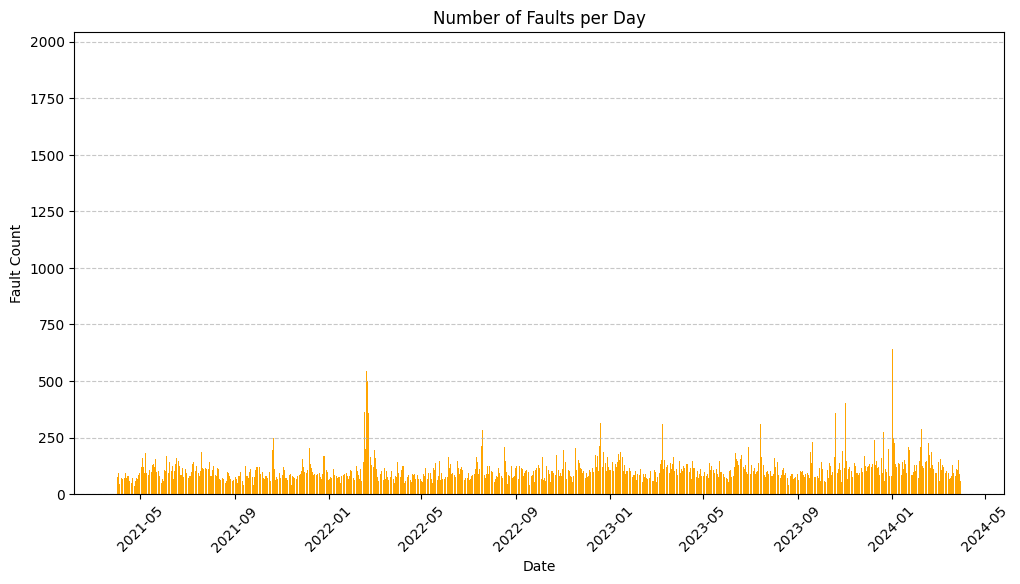

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(faults_epn.index, faults_epn['fault_counts'], color='orange')
plt.title('Number of Faults per Day')
plt.xlabel('Date')
plt.ylabel('Fault Count')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()